# Sentiment analysis using araBERT
## Installing Prerequisites

In [1]:
# !git clone https://github.com/aub-mind/arabert
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Checking for GPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Imports

In [3]:
import pandas as pd
import numpy as np

from farasa.segmenter import FarasaSegmenter
from arabert.preprocess import ArabertPreprocessor, NEVER_SPLIT_TOKENS

preprocessor = ArabertPreprocessor("bert-base-arabert")
preprocess = preprocessor.preprocess
never_split_tokens = NEVER_SPLIT_TOKENS

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score

from transformers import AutoConfig, BertForSequenceClassification, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

[2024-05-05 00:36:16,162 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading and Preparing Data

In [4]:
farasa_segmenter = FarasaSegmenter(interactive=True) # the arabet was built to use this segmenter

df_AJGT = pd.read_excel('datasets/AJGT/AJGT.xlsx',header=0)

DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

df_AJGT = df_AJGT[['Feed', 'Sentiment']]
df_AJGT.columns = [DATA_COLUMN, LABEL_COLUMN]

label_map = {
    'Negative' : 0,
    'Positive' : 1
}

df_AJGT[DATA_COLUMN] = df_AJGT[DATA_COLUMN].apply(lambda x: preprocess(x))
df_AJGT[LABEL_COLUMN] = df_AJGT[LABEL_COLUMN].apply(lambda x: label_map[x])


train_AJGT, test_AJGT = train_test_split(df_AJGT, test_size=0.2,random_state=42)

[2024-05-05 00:36:23,138 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [5]:
test_AJGT

,text,label
1591,و+ الله حرام و+ الله موتو +ه ل+ شعب ال+ أردني ...,0
943,صباح ك+ سعيد,1
869,شخصي +ه تافه,0
162,ال+ حق مش على ل+ جن +ه ال+ تحكيم ال+ حق على ال...,0
1271,ل+ ما تكثر عليا ال+ التزام +ات يصير كل اللي نف...,0
...,...,...
765,رائع و+ ل+ اجمل ? حب رب +نا,1
1465,نرجو من الله +ان يتقبل صلات +نا رغم ما تمر ب+ ...,1
1734,يارب ارزق ال+ عزيمه ل+ اتخاذ ال+ قرار و+ يا رب...,1
1269,ل+ لي مفكر +ين ال+ مفاعل راح يطور +هم ال+ مفاع...,0


Max of train len:  249
Max of test len:  197


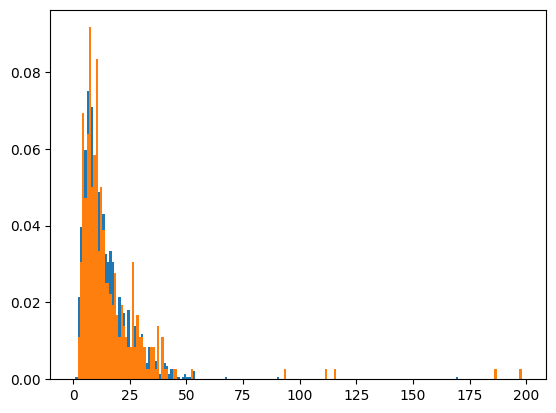

In [6]:
train_sentence_length = [ len(text.split()) for text in train_AJGT['text']]
test_sentence_length = [ len(text.split()) for text in test_AJGT['text']]

print("Max of train len: ",np.max(train_sentence_length))
print("Max of test len: ",np.max(test_sentence_length))
import matplotlib.pyplot as plt

plt.hist(train_sentence_length,bins= range(200),density=True)
plt.hist(test_sentence_length,bins= range(200),density=True)
plt.show()

In [7]:
train_df = pd.DataFrame({
    'id':range(len(train_AJGT)),
    'label':train_AJGT["label"],
    'alpha':['a']*train_AJGT.shape[0],
    'text': train_AJGT["text"].replace(r'\n', ' ', regex=True)
})

dev_df = pd.DataFrame({
    'id':range(len(test_AJGT)),
    'label':test_AJGT["label"],
    'alpha':['a']*test_AJGT.shape[0],
    'text': test_AJGT["text"].replace(r'\n', ' ', regex=True)
})

!mkdir data
train_df.to_csv("data/train.tsv",index=False,columns=train_df.columns,sep='\t',header=False)
dev_df.to_csv("data/dev.tsv",index=False,columns=dev_df.columns,sep='\t',header=False)

A subdirectory or file data already exists.


## Model

That's it!! Now let's build our model

In [8]:
model_name = 'aubmindlab/bert-base-arabert' 
num_labels = 2
task_name = 'classification'
max_length = 128

In [9]:
config = AutoConfig.from_pretrained(model_name,num_labels=num_labels, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False, do_basic_tokenize=True, never_split=never_split_tokens)
tokenizer.max_len = max_length
model = BertForSequenceClassification.from_pretrained(model_name,config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now we need to convert the examples in the dataset to features that the model can understand

In [10]:
train_dataset = SingleSentenceClassificationProcessor(mode='classification')
test_dataset = SingleSentenceClassificationProcessor(mode='classification')

In [11]:
train_dataset.add_examples(texts_or_text_and_labels=train_df['text'],labels=train_df['label'],overwrite_examples = True)
test_dataset.add_examples(texts_or_text_and_labels=dev_df['text'],labels=dev_df['label'],overwrite_examples = True)

print(train_dataset.examples[0])

InputExample(guid=None, text_a='سبحان الله ب+ حمد +ه عدد خلق +ه رضى نفس +ه زن +ه عرش +ه مداد كلم +ات +ه', text_b=None, label=1)


In [12]:
train_features = train_dataset.get_features(tokenizer = tokenizer, max_length = max_length)
test_features = test_dataset.get_features(tokenizer = tokenizer, max_length = max_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [13]:
print(train_features[0])

InputFeatures(input_ids=[29756, 36006, 12695, 448, 3945, 129, 5367, 4095, 129, 4444, 6746, 129, 630, 129, 5383, 129, 21336, 6025, 1012, 129, 29758, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=1)


In [14]:
print(len(train_features))
print(len(test_features))

1440
360


In [15]:
pos_train_labels = np.sum([feature.label for feature in train_features])
pos_test_labels = np.sum([feature.label for feature in test_features])

print(pos_train_labels)
print(pos_test_labels)

707
193


In [16]:
training_args = TrainingArguments("./train")

In [17]:
training_args.do_train = True
training_args.evaluate_during_training = True
training_args.adam_epsilon = 1e-8
training_args.learning_rate = 2e-5
training_args.warmup_steps = 0
training_args.per_gpu_train_batch_size = 16
training_args.per_gpu_eval_batch_size = 16
training_args.num_train_epochs= 5
training_args.logging_steps = (len(train_features) - 1) // training_args.per_gpu_train_batch_size + 1
training_args.save_steps = training_args.logging_steps 
training_args.seed = 42

In [18]:
print(training_args.logging_steps)

90


In [19]:
def compute_metrics(p): #p should be of type EvalPrediction
  print("biiitch")
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  print(confusion_matrix(p.label_ids,preds))

  f1_Positive = f1_score(p.label_ids,preds,pos_label=1,average='binary')
  f1_Negative = f1_score(p.label_ids,preds,pos_label=0,average='binary')
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'f1_pos': f1_Positive,
      'f1_neg': f1_Negative,
      'macro_f1' : macro_f1, 
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

In [20]:
trainer = Trainer(model=model,
                  args = training_args,
                  train_dataset = train_features,
                  eval_dataset = test_features,
                  compute_metrics = compute_metrics)

c:\Python311\Lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


In [21]:
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
  0%|          | 2/450 [00:21<1:23:25, 11.17s/it]

: 

: 